In [243]:
!pip install -U wikipedia
import numpy as np
import wikipedia as wiki
import spacy
import re
import tqdm
import tensorflow
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical  
import warnings
warnings.filterwarnings('ignore')

In [244]:
def process_text(document):
      nlp = spacy.load('en_core_web_sm')
      stopwords = nlp.Defaults.stop_words
      document = re.sub(r'\s+', ' ', document, flags=re.I)  
      document = re.sub(r'\W', ' ', str(document))  
      document = re.sub(r'_', ' ', str(document)) 
      document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)  
      document = document.lower()
      document = re.sub(r'\s+', ' ', document, flags=re.I)  
      doc_spacy = nlp(document)
      lemma_txt = ["".join(token.lemma_) for token in tqdm.tqdm(doc_spacy)]
      lemma_no_stop_txt = [word for word in lemma_txt if word not in stopwords]
      lemma_no_stop_txt = [word for word in lemma_no_stop_txt if len(word) > 3]  
      clean_txt = ' '.join(lemma_no_stop_txt)
      clean_sents_list = [x for x in nlp(clean_txt).sents]
      return clean_sents_list, clean_txt, lemma_no_stop_txt

In [245]:
# Download data (replace with your data acquisition method)
wiki.set_lang('en')

wiki_obj = wiki.page(wiki.search(['Large Language Models deep learning ', 'newest Large Language Models deep learning', 'attention mechanism ', 'transformers in Deep learning']))
data = wiki_obj.content
clean_sents_list, x_train_sents, x_train_clean_txt = process_text(data)


100%|██████████| 2134/2134 [00:00<00:00, 497175.18it/s]


In [246]:
x_train_sents

'generative train transformer type large language model prominent framework generative artificial intelligence artificial neural network natural language processing task base transformer architecture train large data unlabelled text able generate novel human like content 2023 characteristic refer broadly introduce 2018 openai openai release influential foundation model sequentially number comprise series significantly capable previous increase size number trainable parameter train recent release march 2023 model basis task specific system include model fine tune instruction follow turn power chatgpt chatbot service term description model develop example foundation model include series model create eleutherai seven model create cerebra 2023 company different industry develop task specific respective field salesforce einsteingpt bloomberg bloomberggpt finance history initial development generative pretraine long establish concept machine learning application originally form semi supervis

In [247]:
# [token_sent.text for token_sent in clean_sents_list][1]

In [248]:
!pip install arxiv

In [249]:
import arxiv

# Search for articles related to "Large Language Models" (LLMs)
llm_search = arxiv.Search(query=['Large Language Models deep learning '], max_results=100)
llm_results = list(llm_search.results())

llm_papers = ""  

print("Articles related to Large Language Models:")
for result in llm_results:
    llm_papers += f"Title: {result.title}\n\nAbstract: {result.summary}\n\n"  


transformer_search = arxiv.Search(query="Transformers in deep learning", max_results=100)
transformer_results = list(transformer_search.results())

transformer_papers = ""  

print("\nArticles related to Transformers in deep learning:")
for result in transformer_results:
    transformer_papers += f"{result.title}Abstract: {result.summary}"  

all_papers = llm_papers + transformer_papers
# print(all_papers)
data=all_papers+ ' '+ data

Articles related to Large Language Models:

Articles related to Transformers in deep learning:


In [250]:
clean_sents_list, x_train_sents, x_train_clean_txt = process_text(data)

100%|██████████| 19934/19934 [00:00<00:00, 520657.45it/s]


In [251]:
Seq_length=300
def create_dataset(text_data, seq_length=Seq_length):
  chars = sorted(list(set(text_data)))
  char_to_int = dict((c, i) for i, c in enumerate(chars))
  X_data = []
  y_data = []
  for i in range(0, len(text_data) - seq_length, 1):
    seq_in = text_data[i:i + seq_length]  
    seq_out = text_data[i + seq_length]  

    X_data.append([char_to_int[char] for char in seq_in])
  
    y_data.append(char_to_int[seq_out])
    
  return np.array(X_data),np.array(y_data),len(chars)


In [252]:
X,y,char_unique_size=create_dataset(x_train_sents,seq_length=15)
y=y.reshape(len(y),1)
x_catagorical=tensorflow.keras.utils.to_categorical(X)
y_catagorical=tensorflow.keras.utils.to_categorical(y)

y.shape

(98081, 1)

In [253]:
#first preprocess data
#second make training sequances dataset by [seq] -> next char as lable
#make this pairs 
#apply char embedding
#train LSTM model but it may a problem how to handle output from first seq as input for next sequance in lstm 
#firstful we try with const seq_lenth -> after const number of character generate one char in this time its=15
#train model 
#test model 

char_unique_size

38

In [254]:
# model = tensorflow.keras.Sequential()
# model.add(Embedding(char_unique_size,output_dim=64))  
# # model.add(LSTM(units=32,return_sequences=False, activation='tanh'))
# # model.add(Dropout(0.2569))
# model.add(SimpleRNN(units=64,return_sequences=True, activation='relu'))
# model.add(SimpleRNN(units=128,return_sequences=True, activation='relu'))
# model.add(LSTM(units=256,return_sequences=True, activation='tanh'))
# model.add(Dropout(0.2))
# # model.add(Dropout(0.3))

# model.add(SimpleRNN(units=512,return_sequences=False, activation='relu'))
# # model.add(LSTM(units=1024,return_sequences=True, activation='tanh'))
# model.add(Dense(47, activation='softmax'))

In [332]:
# model = tensorflow.keras.Sequential()
# model.add(Embedding(char_unique_size,output_dim=64))  
# model.add(GRU(units=512,return_sequences=False, activation='tanh'))
# # model.add(GRU(units=256,return_sequences=False, activation='tanh'))
# model.add(Dense(128, activation='elu'))
# model.add(Dense(64, activation='elu'))
# model.add(Dense(47, activation='softmax'))
model = tensorflow.keras.Sequential([
  Embedding(char_unique_size, 124),
#   Dropout(0.5),
  GRU(520, return_sequences=True),
  Bidirectional(layer=GRU(340, return_sequences=True,activation='tanh')),
  GlobalMaxPooling1D(),
  Dense(1024, activation='elu'),
  Dense(char_unique_size, activation='softmax'),  
])


In [333]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [334]:
history=model.fit(X,y,epochs=5,batch_size=100)

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.3101 - loss: 2.3275
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6051 - loss: 1.3086
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6712 - loss: 1.0672
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7069 - loss: 0.9387
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7237 - loss: 0.8620


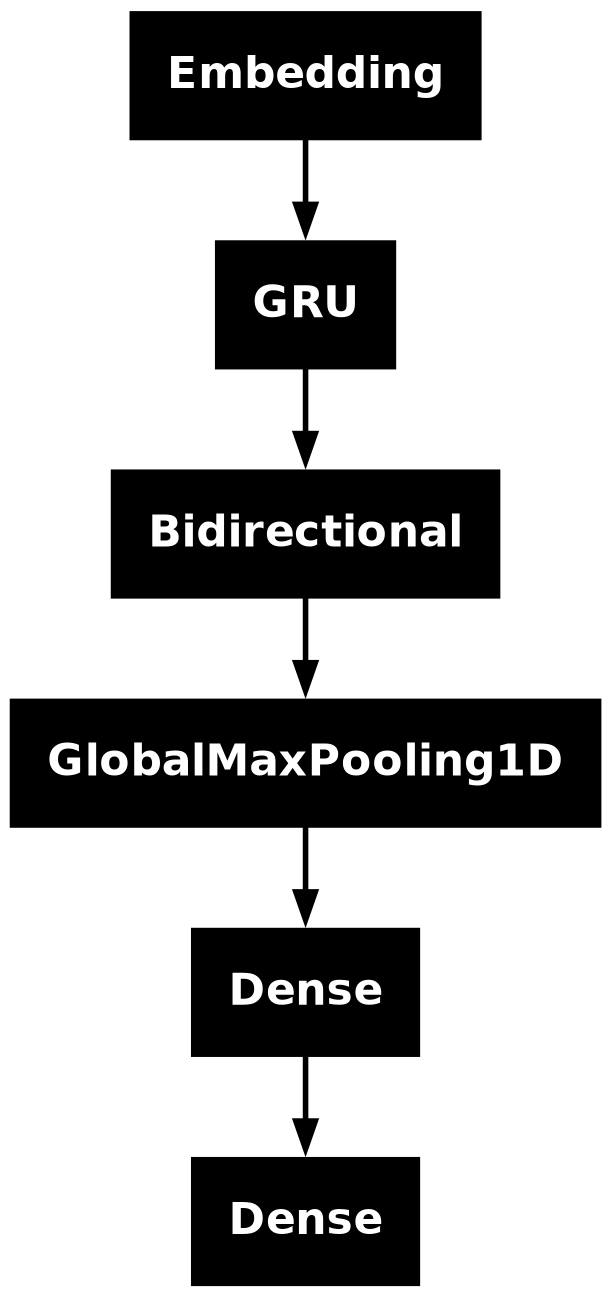

In [335]:
from tensorflow.keras.utils import plot_model
plot_model(model,'/kaggle/working/model2.png')

In [259]:
# def generate_char(model,text):
#     text_preprocessed=preprocess
    

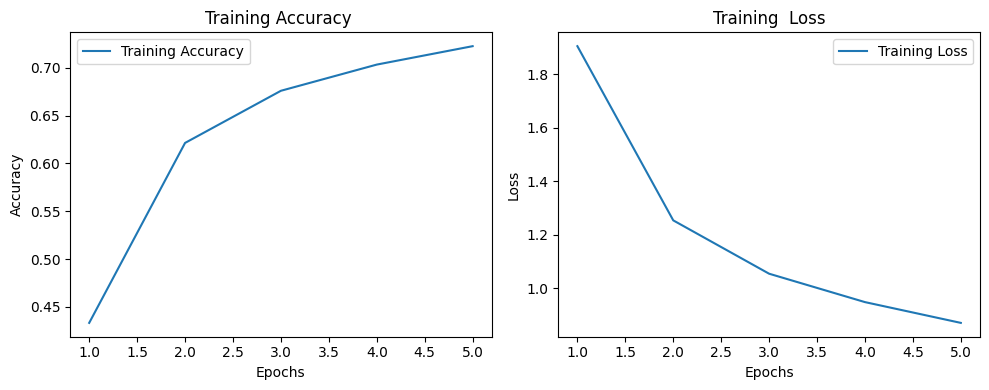

In [336]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    train_accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
#     val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
#     plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy ')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
#     plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training  Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming 'history' contains your training history
# Call the function to plot the training history
plot_training_history(history)


In [349]:
def test_prediction(input_text,model=model, seq_length=Seq_length):
  input_text=input_text[:Seq_length]  
  chars = sorted(list(set(input_text)))
  char_to_int = dict((c, i) for i, c in enumerate(chars))
  print(chars)
  print('input text')
  input_text =input_text
  print(f'input len {len(input_text)}')
  input_seq = [char_to_int[char] for char in input_text]
  input_seq = np.array(input_seq).reshape(1, seq_length)
  int_to_char = dict((i, c) for i, c in enumerate(chars))

  prediction = model.predict(input_seq)
  print(len(int_to_char))  # Optional for debugging

  return int_to_char[np.argmax(prediction)]


def test_predictio_random(model=model, input_text=x_train_sents, seq_length=Seq_length):
  all_text=input_text
  random_start_index=np.random.randint(0,len(list((input_text)))-seq_length)
  input_text=input_text[random_start_index:random_start_index+Seq_length]  
  print(f'testing portion is ---> {input_text}')
  chars = (list(set(input_text)))
  char_to_int = dict((c, i) for i, c in enumerate(chars))
#   print(chars)
  print('input text')
  input_text =input_text
  print(f'input len {len(input_text)}')
  input_seq = [char_to_int[char] for char in input_text]
  input_seq = np.array(input_seq).reshape(1, seq_length)
  int_to_char = dict((i, c) for i, c in enumerate(chars))

  prediction = model.predict(input_seq)
#   print(len(int_to_char))  # Optional for debugging
  print(f'true char is {all_text[random_start_index+1]}')
  return int_to_char[np.argmax(prediction)]



In [350]:
np.random.randint(0,len(list(x_train_sents))-300)

71848

In [351]:
x_train_sents[1204]

'i'

In [503]:
test_predictio_random()

testing portion is ---> ['example', 'deep', 'learn', 'characterization', 'divergenceabstract']


ValueError: cannot reshape array of size 11621 into shape (1,5)

In [370]:
test_prediction(x_train_sents[904:1204])

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'w', 'x', 'y']
input text
input len 300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
24


KeyError: 24

In [ ]:
test_prediction_random()

In [ ]:
Seq_length=300
def create_dataset(text_data, seq_length=Seq_length):
  chars = sorted(list(set(text_data)))
  char_to_int = dict((c, i) for i, c in enumerate(chars))
  X_data = []
  y_data = []
  for i in range(0, len(process_text(text_data))- seq_length, 1):
    seq_in = text_data[i:i + seq_length]  
    seq_out = text_data[i + seq_length]  
    X_data.append([char_to_int[char] for char in seq_in])
    y_data.append(char_to_int[seq_out])  
  return np.array(X_data),np.array(y_data),len(chars)


In [ ]:
# def create_dataset_dynamic_sequances(text_data):

#   input_seq=[]
#   output_seq=[]
#   chars = sorted(list(set(text_data)))
#   char_to_int = dict((c, i) for i, c in enumerate(chars))
#   X_data = []
#   y_data = []

#   for i in range(1, len(text_data)):
#      n_gram_seq = token_list[:i+1]
#      output_=token_list[:i+2]
#      input_seq.append([char_to_int(j) for j in n_gram_seq])
#      output_seq.append(char_to_int(k) for k in output_)
#   max_seq_length = max(len(x) for x in input_seq)
#   print(max_seq_length)
#   input_seq = np.array(pad_sequences(input_seq, maxlen=max_seq_length, padding='pre'))

#   return np.array(X_data), np.array(y_data), len(chars)
def create_dataset_all_sequences(text_data):
  chars = sorted(list(set(text_data)))
  char_to_int = dict((c, i) for i, c in enumerate(chars))
  X_data = []
  y_data = []

  # Loop through all starting positions in the text data
  for start_index in range(len(text_data)):
    # Loop through sequence lengths from 1 to a maximum length (can be adjusted)
    for seq_len in range(1, len(text_data) - start_index + 1):
      # Create input sequence
      input_seq = [char_to_int[char] for char in text_data[start_index:start_index + seq_len]]
      # Create target sequence (shifted by 1 character)
      target_seq = [char_to_int[char] for char in text_data[start_index + 1:start_index + seq_len + 1]]
      X_data.append(input_seq)
      y_data.append(target_seq)
  X_data = np.array(X_data)
  y_data = np.array(y_data)
  return X_data, y_data, char_to_int


In [ ]:
X_dynamic_sequances,y_dynamic_sequances,char_unique_size=create_dataset_all_sequences(x_train_sents)
# y_dynamic_sequances=y_dynamic_sequances.reshape(len(y_dynamic_sequances),1)
X_dynamic_sequances.shape

# word Based generator training model

In [ ]:
x_train_sents.split()

In [440]:
import numpy as np

Words_Seq_length = 5

def create_dataset_word_based(text_data=x_train_sents, seq_length=Words_Seq_length):
    words = text_data.split()
    unique_words = sorted(set(words))
    word_to_int = {w: i for i, w in enumerate(unique_words)}
    int_to_word = {i: w for i, w in enumerate(unique_words)}

    X_data_words = []
    y_data_words = []
    for i in range(len(words) - seq_length):
        seq_in = words[i:i + seq_length]
        seq_out = words[i + seq_length]
        X_data_words.append([word_to_int[word] for word in seq_in])
        y_data_words.append(word_to_int[seq_out])
#     z=[int_to_word[word]for word in X_data_words[0]]
#     print(z)
    return np.array(X_data_words), np.array(y_data_words), len(unique_words)


In [442]:
X_wordSeq_training,Y_wordSEQ_training,UNique_words_len=create_dataset_word_based()

In [506]:
# model_word_generation=tensorflow.keras.Sequential([
#   Embedding(UNique_words_len, 124),
# #   LSTM(520, return_sequences=True),
#   Bidirectional(layer=LSTM(340, return_sequences=True,activation='tanh')),
#   GlobalMaxPooling1D(),
#   Dense(1024, activation='relu'),
#   Dense(1024, activation='elu'),

#   Dense(UNique_words_len, activation='softmax'),  
# ])
model_word_generation = tensorflow.keras.Sequential()
model_word_generation.add(Embedding(UNique_words_len, 312))
model_word_generation.add(LSTM(256, input_shape=(X.shape[1], 312),return_sequences=True))
model_word_generation.add(Dropout(0.2))
model_word_generation.add(LSTM(256))
model_word_generation.add(Dropout(0.2))
model_word_generation.add(Dense(UNique_words_len, activation='softmax'))
model_word_generation.compile(loss='categorical_crossentropy', optimizer='adam')


In [507]:
model_word_generation.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [509]:
model_word_generation.fit(X_wordSeq_training,Y_wordSEQ_training,epochs=20,batch_size=50)

Epoch 1/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4386 - loss: 2.7252
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4675 - loss: 2.5551
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5484 - loss: 2.2088
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6127 - loss: 1.9253
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6645 - loss: 1.7245
Epoch 6/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7064 - loss: 1.5009
Epoch 7/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7455 - loss: 1.3204
Epoch 8/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7737 - loss: 1.2045
Epoch 9/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8047 - loss: 1.0563
Epoch 10/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8281 - loss: 0.9461
Epoch 11/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8554 - loss: 0.8240
Epoch 12/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [ ]:
# def test_word_based_gen_model(text_data, seq_length=Words_Seq_length):
#     words = text_data.split()
#     unique_words = sorted(set(words))
#     word_to_int = {w: i for i, w in enumerate(unique_words)}
#     int_to_word = {i: w for i, w in enumerate(unique_words)}

#     X_data_words = []
#     y_data_words = []
#     for i in range(len(words) - seq_length):
#         seq_in = words[i:i + seq_length]
#         seq_out = words[i + seq_length]
#         X_data_words.append([word_to_int[word] for word in seq_in])
#         y_data_words.append(word_to_int[seq_out])
# #     z=[int_to_word[word]for word in X_data_words[0]]
# #     print(z)
#     return np.array(X_data_words), np.array(y_data_words), len(unique_words)



In [516]:
def test_prediction_random_word_based_model_gen(model=model_word_generation, input_text=x_train_sents, seq_length=Words_Seq_length):
    all_text = input_text
    words = input_text.split()  # Can be commented out if not needed later
    
    if len(words) < seq_length:
        print("Input text is too short for the specified sequence length.")
        return None
    
    random_start_index = np.random.randint(0, len(words) - seq_length)
    input_text = words[random_start_index:random_start_index + seq_length]  # Extract sequence
    print(f'testing portion is ---> {input_text}')

    unique_words = sorted(list(set(words)))  # Use words if needed, otherwise remove this line

    word_to_int = {w: i for i, w in enumerate(unique_words)}
    int_to_word = {i: w for i, w in enumerate(unique_words)}

    input_seq = [word_to_int[word] for word in input_text]
    input_seq = np.array(input_seq).reshape(1, seq_length)
    prediction = model.predict(input_seq)

    print(f'true word is {all_text.split()[random_start_index + seq_length]}')
    return int_to_word[np.argmax(prediction)]


In [523]:
test_prediction_random_word_based_model_gen()

testing portion is ---> ['natural', 'language', 'processing', 'promptly', 'develop']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
true word is computer


'computer'

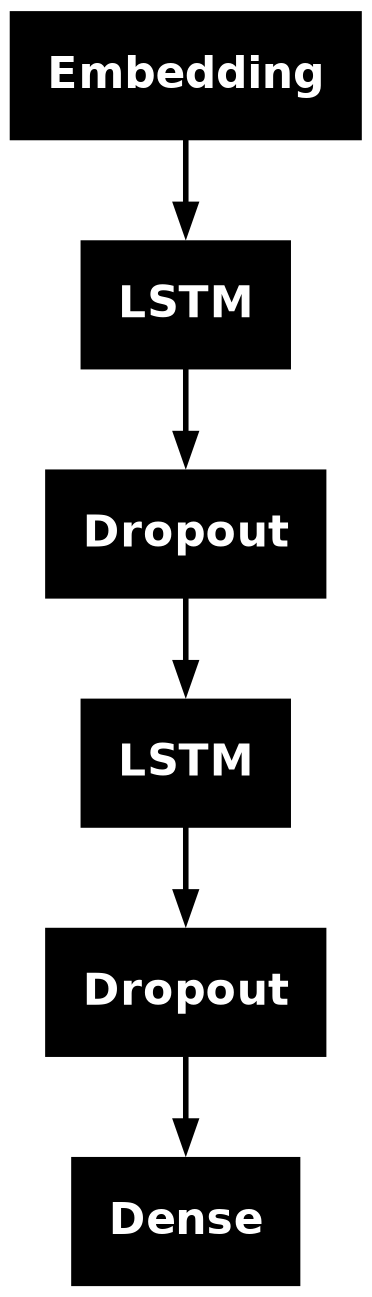

In [519]:
plot_model(model_word_generation,'/kaggle/working/model_word_gen.png')